<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [2]:
from importlib import reload
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import utils_covid
from utils_covid import *
from GP_models import GP_classic as GP_naive
from GP_models import GP_sig_precomputed as GP_sig
import experiments
from experiments import * 
import signature_features_covid
from signature_features_covid import *

In [3]:
data_covid = pd.read_csv('covid_data/us-counties.csv')
pop_state = pd.read_csv('covid_data/SCPRC-EST2019-18+POP-RES.csv')
pop_county = pd.read_csv('covid_data/co-est2019-alldata.csv',encoding = "ISO-8859-1")

In [4]:
pop_county['CTYNAME'] = pop_county['CTYNAME'].apply(lambda x: x.split(' County')[0])
pop_county['CTYNAME'] = pop_county['CTYNAME'].apply(lambda x: x.split(' Parish')[0])
pop_county['CTYNAME'] = pop_county['CTYNAME'].apply(lambda x: x.split(' Municipality')[0])
pop_county['CTYNAME'] = pop_county['CTYNAME'].apply(lambda x: x.split(' City')[0])

In [5]:
data_covid['county'] = data_covid['county'].apply(lambda x: x.split(' City')[0])
data_covid['county'] = data_covid['county'].apply(lambda x: x.split(' City')[0])

Change the data into the format compatible with our code.\\

N_bags x N_items x time x dim <-> N_states x N_counties x time x 2

However, we won't have the same number of counties per state, hence need to adapt the code base

Also, the times are not the same for each county

In [6]:
data_covid['county']
states = list(set(data_covid.state.values))
states_pop = list(set(pop_state.NAME.values))
N_states = len(states)

for state in states:
    if not state in states_pop:
        print(state)
        

Puerto Rico
Northern Mariana Islands
Guam
Virgin Islands


In [478]:
bags = []
labels = []
weigthed_labels = []
count=0
last_day = []
pop = []
weights = []
list_df = {}

for state in states_pop:

    bag = []
    label = []
    weight = []
    
    state_data = data_covid[data_covid['state']==state]
    counties_state = list(set(state_data.county.values))
    
    df = pd.DataFrame(columns=['date','county','cases','death'])
    
    for county in counties_state:
        
        
        
        item = state_data[state_data['county']==county]
        
        item = item[item['date']<'2020-03-31']
        np_item = item[['cases','deaths']].to_numpy()
        
        if len(np_item)<10 or county=='Unknown':
            count+=1
        else:
          
            #tot_pop = pop_state[pop_state['NAME']==state]['POPESTIMATE2019'].values[0]
            county_pop = pop_county[pop_county['CTYNAME']==county]['POPESTIMATE2019'].values[0]
       
            bag.append(np.diff(np_item[:-1,:-1],axis=0))
            label.append(np_item[-1,-1]-np_item[-2,-1])
            #bag.append(100*np_item[:-1,:]/population)
            #label.append(100.*np_item[-1,-1]/population)
            last_day.append(item['date'].values[-1])
            weight.append(county_pop)
    if len(bag)>=1:
        list_df[state]=df
        name_states.append(state)
        if sum(label)<80:
            bags.append(bag)
            labels.append(label)
            #pop.append(population)
            weights.append(weight)

print(count)

1416


In [479]:
print(len(list_df))
print(len(labels))
print(max([sum(e) for e in labels]))

50
49
63


In [480]:
np.diff([1,3,10])

array([2, 7])

In [481]:
weights_ = [[np.float64(county)/np.float64(sum(state)) for county in state] for state in weights]

Train test split

In [482]:
#y_weighted = [np.sum([np.array(weights_[i])*np.array(labels[i])]) for i,e in enumerate(labels)]
#y_weighted = [1000*np.sum(np.array(labels[i]))/np.sum(np.array(weights[i])) for i,e in enumerate(labels)]
y_weighted = [np.sum(labels[i]) for i in range(len(labels))]
y_weighted = np.array(y_weighted)[:,None]
y = [np.mean(e) for i,e in enumerate(labels)]
y = np.array(y)[:,None]

In [485]:
reload(utils_covid)
data_aug = []
for i in range(len(bags)):
    data_aug.append(utils_covid.add_dimension2(bags[i],add_time=True,lead_lag=[1]))
bags[0][0].shape
#data_aug = [e.copy() for e in bags]

(11, 1)

32
17


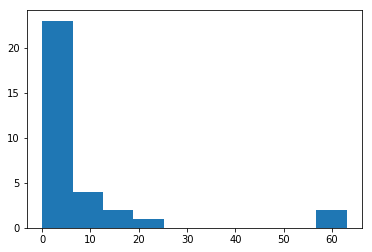

(21, 3)


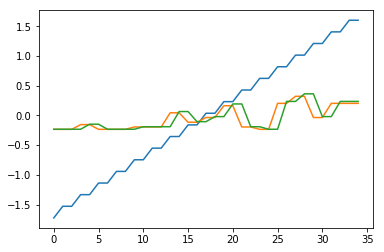

In [486]:
reload(utils_covid)
data_scaled, y_scaled, train_index, test_index = utils_covid.split_standardize(y_weighted,data_aug,standardized_input=True, standardized_label=False,method='stratify',random_state=1)

print(len(train_index))
print(len(test_index))
plt.hist(y_scaled[train_index,:])
plt.show()
print(data_scaled[0][0].shape)
plt.plot(data_scaled[5][0])
plt.show()


In [491]:
# # specs for expected sig 
reload(signature_features_covid)
reload(experiments)
reload(GP_sig)
sig_level1 = 2
M = 20000

results = []



# pathwise expected sig  
#expected_pathwise_sig,bags_before,bags_after = signature_features_covid.scaled_expected_sig([e.copy() for e in data_scaled],sig_level1,M=M,a=1,ilya_rescale=True,return_norms=True)
expected_pathwise_sig = signature_features_covid.scaled_expected_sig([e.copy() for e in data_scaled],sig_level1,M=M,a=1,ilya_rescale=False,return_norms=False)#,weights=weights_)


maxi 40000.0


In [492]:
# fig,ax = plt.subplots(1,2,figsize=(15,5))
# ax[0].hist(bags_before)
# ax[1].hist(bags_after)
# plt.show()

In [493]:
pop_scaled=pop
#print(pop_scaled)
#features = []
#for i in range(len(expected_pathwise_sig)):
 #   features.append(np.insert(expected_pathwise_sig[i],0,pop_scaled[i]))
#features = np.array(features)
#print(features.shape)
features = expected_pathwise_sig

scaler = StandardScaler()
to_fit = [features[i] for i in train_index]
scaler.fit(to_fit)
features = scaler.transform(features)
print(features.shape)

(49, 12)


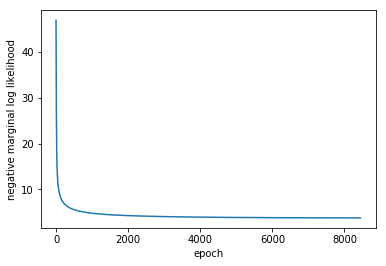

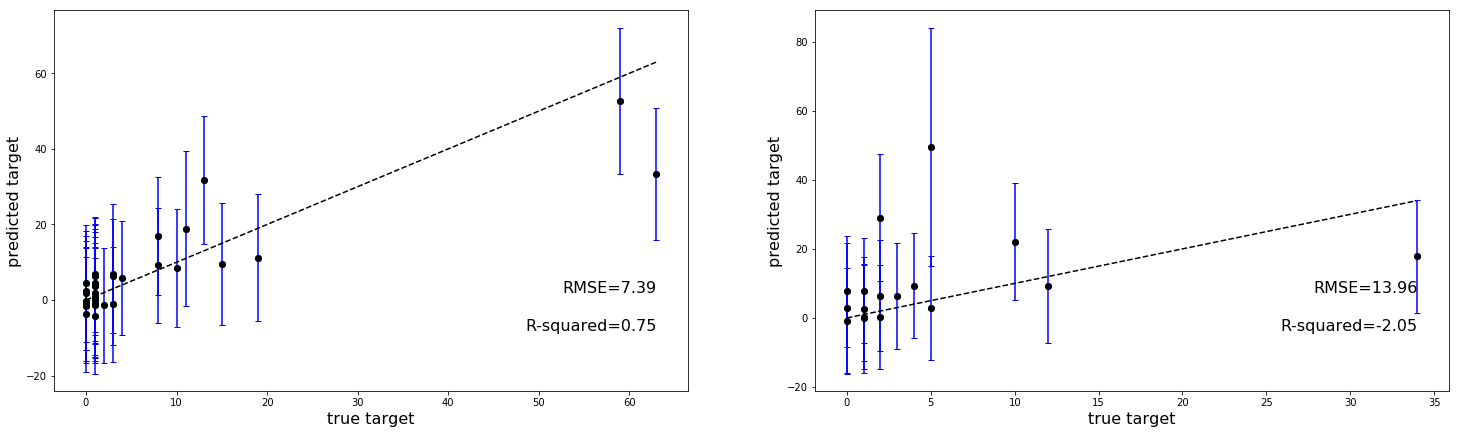

In [495]:

K_precomputed = experiments.precompute_K(features)
RMSE_train, R2_train, RMSE_test, R2_test = experiments.experiment_precomputed(K_precomputed, y_scaled,train_index,test_index,param_init=[0,0,0],RBF=False,plot=True)


In [1042]:
# # specs for pathwise expected sig
# reload(signature_features_covid)
# reload(experiments)
# reload(GP_sig)
# sig_level1 = 2
# M1 = 10
# M2 = 10
# window = 0

# # specs for signature
# sig_level2 = 2


# results = []


# # pathwise expected sig  
# expected_pathwise_sig = signature_features_covid.scaled_pathwise_expected_iisignature([e.copy() for e in data_scaled],sig_level1,M=M1,a=1,ilya_rescale=True,return_norms=False)
# # final features 
# #signatures = signatory.signature(torch.tensor(expected_pathwise_sig),sig_level2)
# signatures = signature_features_covid.scale_path_ilya(expected_pathwise_sig,sig_level2,M=M2,a=1, return_norms=False)
# K_precomputed = experiments.precompute_K(signatures)
# RMSE_train, R2_train, RMSE_test, R2_test = experiments.experiment_precomputed(K_precomputed, y_scaled,train_index,test_index, param_init=[0,5,0],RBF=False,plot=True)
# results.append(R2_test)

# print(np.mean(results))
      

In [541]:
df=pd.read_csv('https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.csv')

In [542]:
df.fillna(0., inplace=True)

In [543]:
df.columns.unique()

Index(['date', 'granularite', 'maille_code', 'maille_nom', 'cas_confirmes',
       'deces', 'deces_ehpad', 'reanimation', 'hospitalises', 'gueris',
       'depistes', 'source_nom', 'source_url', 'source_archive',
       'source_type'],
      dtype='object')

In [544]:
df.granularite.unique()

array(['departement', 'pays', 'region', 'monde', 'collectivite-outremer'],
      dtype=object)

In [605]:
df[df.granularite=='region'].head()

,date,granularite,maille_code,maille_nom,cas_confirmes,deces,deces_ehpad,reanimation,hospitalises,gueris,depistes,source_nom,source_url,source_archive,source_type
15,2020-01-24,region,REG-11,Île-de-France,2.0,0.0,0.0,0.0,2.0,0.0,0.0,Santé publique France,https://www.santepubliquefrance.fr/maladies-et...,https://web.archive.org/web/20200124202351/htt...,sante-publique-france
16,2020-01-24,region,REG-11,Île-de-France,2.0,0.0,0.0,0.0,2.0,0.0,0.0,Ministère des Solidarités et de la Santé,https://solidarites-sante.gouv.fr/IMG/pdf/2001...,https://web.archive.org/web/20200322183046/htt...,ministere-sante
17,2020-01-24,region,REG-75,Nouvelle-Aquitaine,1.0,0.0,0.0,0.0,0.0,0.0,0.0,ARS Nouvelle-Aquitaine,https://www.nouvelle-aquitaine.ars.sante.fr/co...,0,agences-regionales-sante
18,2020-01-24,region,REG-75,Nouvelle-Aquitaine,1.0,0.0,0.0,0.0,1.0,0.0,0.0,Santé publique France,https://www.santepubliquefrance.fr/maladies-et...,https://web.archive.org/web/20200124202351/htt...,sante-publique-france
19,2020-01-24,region,REG-75,Nouvelle-Aquitaine,1.0,0.0,0.0,0.0,1.0,0.0,0.0,Ministère des Solidarités et de la Santé,https://solidarites-sante.gouv.fr/IMG/pdf/2001...,https://web.archive.org/web/20200322183046/htt...,ministere-sante


In [610]:
df[df.granularite=='departement'][df.maille_code=='DEP-01'].head()

/Users/maudlemercier/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,date,granularite,maille_code,maille_nom,cas_confirmes,deces,deces_ehpad,reanimation,hospitalises,gueris,depistes,source_nom,source_url,source_archive,source_type
250,2020-03-02,departement,DEP-01,Ain,3.0,0.0,0.0,0.0,0.0,0.0,0.0,ARS Auvergne-Rhône-Alpes,https://www.auvergne-rhone-alpes.ars.sante.fr/...,https://web.archive.org/web/20200321171945/htt...,agences-regionales-sante
295,2020-03-03,departement,DEP-01,Ain,3.0,0.0,0.0,0.0,0.0,0.0,0.0,ARS Auvergne-Rhône-Alpes,https://www.auvergne-rhone-alpes.ars.sante.fr/...,https://web.archive.org/web/20200321171859/htt...,agences-regionales-sante
353,2020-03-04,departement,DEP-01,Ain,4.0,0.0,0.0,0.0,0.0,0.0,0.0,ARS Auvergne-Rhône-Alpes,https://www.auvergne-rhone-alpes.ars.sante.fr/...,https://web.archive.org/web/20200321171826/htt...,agences-regionales-sante
441,2020-03-05,departement,DEP-01,Ain,4.0,0.0,0.0,0.0,0.0,0.0,0.0,ARS Auvergne-Rhône-Alpes,https://www.auvergne-rhone-alpes.ars.sante.fr/...,https://web.archive.org/web/20200321171638/htt...,agences-regionales-sante
542,2020-03-06,departement,DEP-01,Ain,4.0,0.0,0.0,0.0,0.0,0.0,0.0,ARS Auvergne-Rhône-Alpes,https://www.auvergne-rhone-alpes.ars.sante.fr/...,https://web.archive.org/web/20200321171716/htt...,agences-regionales-sante


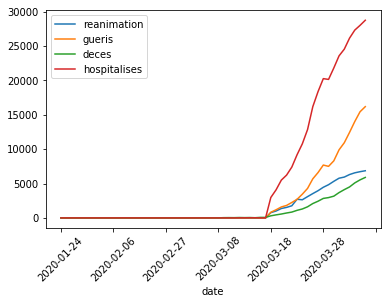

In [599]:
df[df.granularite=='departement'].groupby('date').sum()[['reanimation','gueris','deces','hospitalises']].plot(rot=45)

plt.show()

In [532]:
df[df.granularite=='region'].groupby(['maille_nom', 'date']).sum()

cas_confirmes   deces  deces_ehpad  \
maille_nom           date                                             
Auvergne-Rhône-Alpes 2020-02-07            5.0     0.0          0.0   
                     2020-02-08           10.0     0.0          0.0   
                     2020-02-10            5.0     0.0          0.0   
                     2020-02-11            5.0     0.0          0.0   
                     2020-02-12            5.0     0.0          0.0   
...                                        ...     ...          ...   
Île-de-France        2020-04-01            0.0  1369.0          0.0   
                     2020-04-02            0.0  1571.0          0.0   
                     2020-04-03            0.0  1791.0          0.0   
                     2020-04-04            0.0  1967.0          0.0   
                     2020-04-05            0.0  2107.0          0.0   

                                 reanimation  hospitalises  gueris  depistes  
maille_nom           date                                                     
Auvergne-Rhône-Alpes 2020-02-07          0.0           5.0     0.0       0.0  
                     2020-02-08          0.0          10.0     0.0       0.0  
                     2020-02-10          0.0           5.0     0.0       0.0  
                     2020-02-11          0.0           5.0     0.0       0.0  
                     2020-02-12          0.0           5.0     0.0       0.0  
...                                      ...           ...     ...       ...  
Île-de-France        2020-04-01       2204.0        9609.0  3432.0       0.0  
                     2020-04-02       2301.0       10273.0  3887.0       0.0  
                     2020-04-03       2375.0       10824.0  4417.0       0.0  
                     2020-04-04       2436.0       11214.0  4881.0       0.0  
                     2020-04-05       2506.0       11474.0  5166.0       0.0  

[679 rows x 7 columns]

In [533]:
df[df.granularite=='departement'].groupby(['maille_nom', 'date']).sum()

cas_confirmes  deces  deces_ehpad  reanimation  \
maille_nom date                                                         
Ain        2020-03-02            3.0    0.0          0.0          0.0   
           2020-03-03            3.0    0.0          0.0          0.0   
           2020-03-04            4.0    0.0          0.0          0.0   
           2020-03-05            4.0    0.0          0.0          0.0   
           2020-03-06            4.0    0.0          0.0          0.0   
...                              ...    ...          ...          ...   
Yvelines   2020-04-01            0.0  119.0          0.0        178.0   
           2020-04-02            0.0  137.0          0.0        180.0   
           2020-04-03            0.0  155.0          0.0        185.0   
           2020-04-04            0.0  168.0          0.0        189.0   
           2020-04-05            0.0  175.0          0.0        185.0   

                       hospitalises  gueris  depistes  
maille_nom date                                        
Ain        2020-03-02           0.0     0.0       0.0  
           2020-03-03           0.0     0.0       0.0  
           2020-03-04           0.0     0.0       0.0  
           2020-03-05           0.0     0.0       0.0  
           2020-03-06           0.0     0.0       0.0  
...                             ...     ...       ...  
Yvelines   2020-04-01         815.0   347.0       0.0  
           2020-04-02         837.0   394.0       0.0  
           2020-04-03         858.0   436.0       0.0  
           2020-04-04         913.0   454.0       0.0  
           2020-04-05         909.0   470.0       0.0  

[3084 rows x 7 columns]